# EDA for Age-Gender Classification dataset

## Introduction
UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc. Some sample images are shown as following

## Highlights
- consists of 20k+ face images in the wild (only single face in one image)
- provides the correspondingly aligned and cropped faces
- provides the corresponding landmarks (68 points)
- images are labelled by age, gender, and ethnicity

## Labels
The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

- [age] is an integer from 0 to 116, indicating the age
- [gender] is either 0 (male) or 1 (female)
- [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
- [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


# EDA

In [ ]:
def parse_filepath(filepath):
    """Parse UTKFace filepath to extract age, gender, and race information"""
    try:
        # Expected format: [age]_[gender]_[race]_[date&time].jpg
        filename = filepath.stem
        age, gender, race, _ = filename.split('_')
        return {
            'filepath': str(filepath),
            'age': int(age),
            'gender': int(gender),  # 0: male, 1: female
            'race': int(race)
        }
    except:
        return None

def create_dataset_df(data_dir):
    """Create a DataFrame with image metadata"""
    image_paths = Path(data_dir).glob('*.jpg')
    records = []
    for filepath in image_paths:
        record = parse_filepath(filepath)
        if record:
            records.append(record)
    return pd.DataFrame(records)

def plot_age_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='age', bins=30)
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()

    print("\nAge Statistics:")
    print(df['age'].describe())

def plot_gender_distribution(df):
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='gender')
    plt.title('Gender Distribution')
    plt.xticks([0, 1], ['Male', 'Female'])
    plt.show()

    print("\nGender Distribution:")
    print(df['gender'].value_counts(normalize=True))

def load_sample_images(df, num_samples=5):
    plt.figure(figsize=(15, 3))
    sample_indices = np.random.choice(len(df), num_samples, replace=False)
    
    for idx, i in enumerate(sample_indices):
        img_path = df.iloc[i]['filepath']
        img = load_img(img_path, target_size=(128, 128))
        plt.subplot(1, num_samples, idx + 1)
        plt.imshow(img)
        plt.title(f"Age: {df.iloc[i]['age']}\nGender: {'F' if df.iloc[i]['gender'] == 1 else 'M'}")
        plt.axis('off')
    plt.show()

In [ ]:
DATA_DIR = r"C:\Users\kresi\OneDrive\Desktop\Turing college\DL\Age Gender\data\UTKFace"

## Basic understanding of the dataset structure

In [3]:
df = create_dataset_df(DATA_DIR)

print("Dataset Overview:")
print(df.info())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  23705 non-null  object
 1   age       23705 non-null  int64 
 2   gender    23705 non-null  int64 
 3   race      23705 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 740.9+ KB
None


- 23,705 images total
- Complete data (no null values)
- Includes age, gender, and race information

## Age distribution visualization

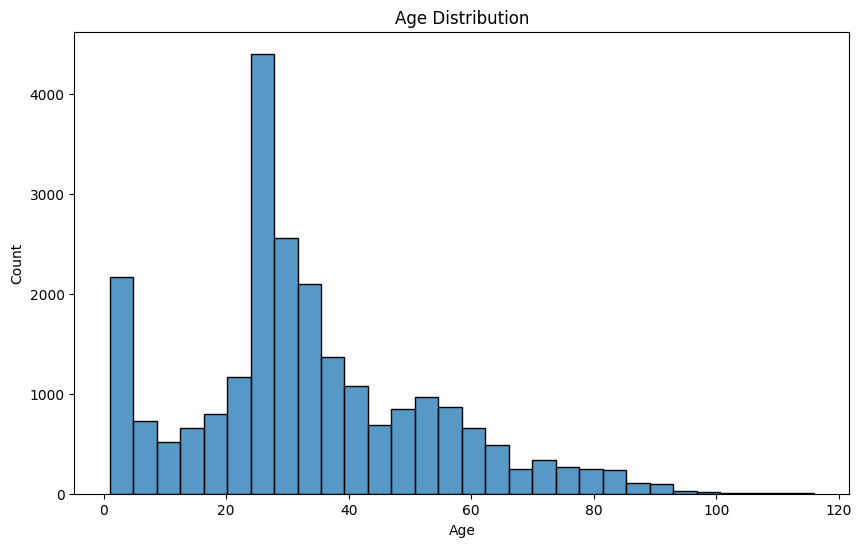


Age Statistics:
count    23705.000000
mean        33.300907
std         19.885708
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64


In [4]:
plot_age_distribution(df)

- Ages range from 1 to 116 years
- Mean age is ~33 years
- Strong peak around 25-35 years
- Significant imbalance with fewer samples for elderly people (>70)
- Large number of young children (0-10)

## Gender distribution visualization

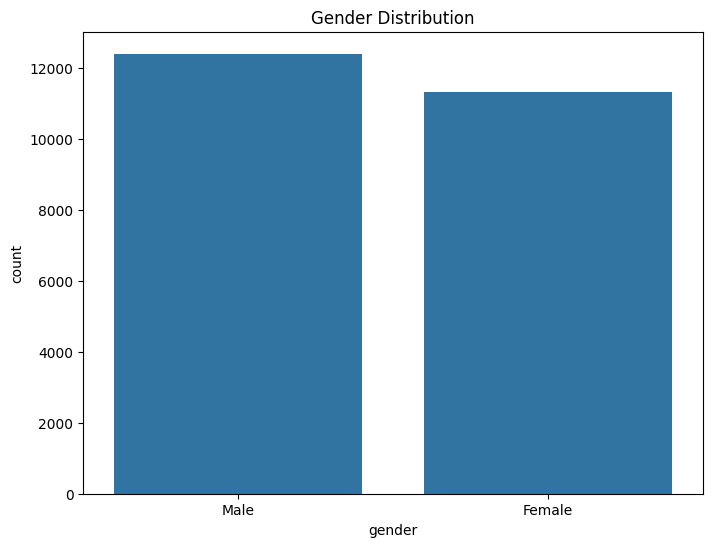


Gender Distribution:
gender
0    0.522717
1    0.477283
Name: proportion, dtype: float64


In [5]:
plot_gender_distribution(df)

- Relatively balanced: 52.3% male, 47.7% female
- This is good news as it reduces potential gender bias

## Sample images with their labels

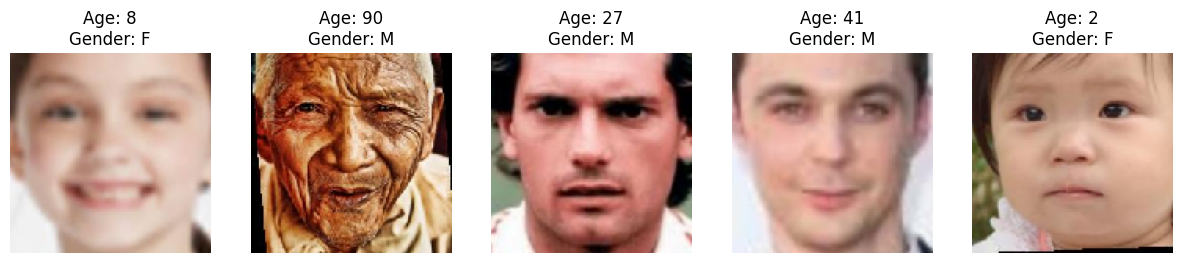

In [6]:
load_sample_images(df)

In [ ]:
def analyze_age_by_gender(df):
    """Analyze age distribution by gender"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x='gender', y='age')
    plt.title('Age Distribution by Gender')
    plt.xticks([0, 1], ['Male', 'Female'])
    
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df[df['gender']==0], x='age', label='Male')
    sns.kdeplot(data=df[df['gender']==1], x='age', label='Female')
    plt.title('Age Density by Gender')
    plt.legend()
    plt.show()
    
    print("\nAge Statistics by Gender:")
    print(df.groupby('gender')['age'].describe())

def analyze_age_groups(df):
    """Analyze age groups distribution"""
    df['age_group'] = pd.cut(df['age'], 
                             bins=[0, 12, 18, 30, 45, 60, 75, 100, 120],
                             labels=['Child', 'Teen', 'Young Adult', 
                                     'Adult', 'Middle Age', 'Senior', 
                                     'Elderly', '80+'])
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    age_group_counts = df['age_group'].value_counts()
    plt.bar(range(len(age_group_counts)), age_group_counts.values)
    plt.xticks(range(len(age_group_counts)), age_group_counts.index, rotation=45)
    plt.title('Distribution of Age Groups')
    
    ax2 = plt.subplot(1, 2, 2)  # Use the ax2 variable
    gender_age_counts = pd.crosstab(df['age_group'], df['gender'], normalize='index') * 100
    gender_age_counts.plot(kind='bar', stacked=True, ax=ax2)  # Specify ax=ax2
    plt.title('Gender Distribution Within Age Groups')
    plt.legend(['Male', 'Female'])
    plt.xticks(rotation=45)
    plt.ylabel('Percentage')
    
    plt.tight_layout()
    plt.show()
    
    print("\nSample counts by age group:")
    print(df['age_group'].value_counts().sort_index())
    
def analyze_data_quality(df):
    """Analyze potential data quality issues"""
    plt.figure(figsize=(15, 5))
    
    age_counts = df['age'].value_counts().sort_index()
    plt.subplot(1, 2, 1)
    plt.plot(age_counts.index, age_counts.values)
    plt.title('Number of Samples per Age')
    plt.xlabel('Age')
    plt.ylabel('Count')
    
    rare_ages = age_counts[age_counts < 10]
    print("\nAges with less than 10 samples:")
    print(rare_ages)
    
    plt.subplot(1, 2, 2)
    plt.scatter(df['age'], df['gender'], alpha=0.1)
    plt.title('Age vs Gender Distribution')
    plt.ylabel('Gender (0=Male, 1=Female)')
    plt.tight_layout()
    plt.show()

def analyze_race_distribution(df):
    """Analyze race distribution and its relationship with other variables"""
    plt.figure(figsize=(10, 5))
    race_counts = df['race'].value_counts()
    plt.bar(range(len(race_counts)), race_counts.values)
    plt.title('Distribution of Race Categories')
    plt.xlabel('Race Category')
    plt.ylabel('Count')
    plt.show()

    race_gender_dist = pd.crosstab(df['race'], df['gender'], 
                                  normalize='index') * 100
    print("\nGender distribution within each race category (%):")
    print(race_gender_dist)

## Age distribution across genders

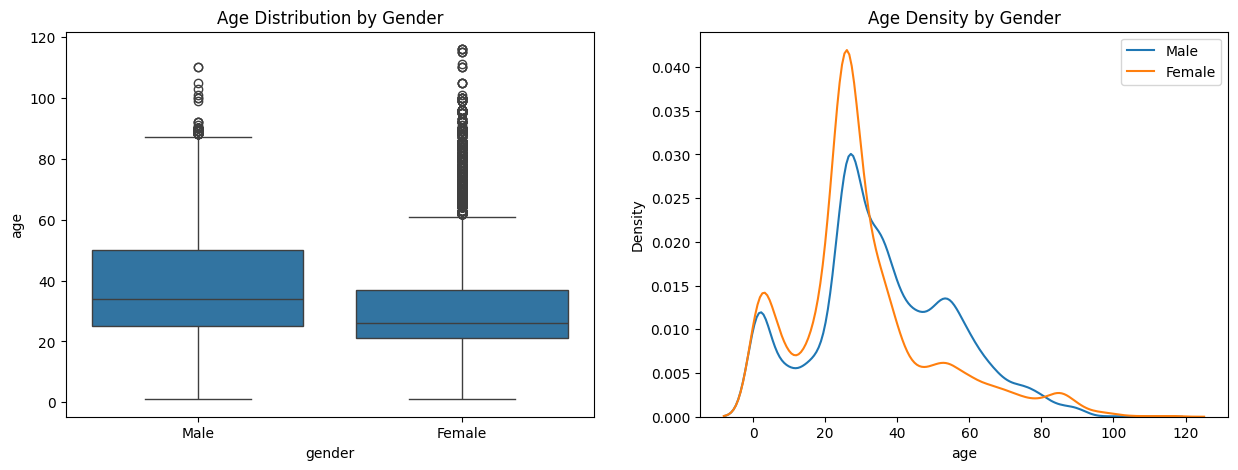


Age Statistics by Gender:
          count       mean        std  min   25%   50%   75%    max
gender                                                             
0       12391.0  35.695666  19.705223  1.0  25.0  34.0  50.0  110.0
1       11314.0  30.678186  19.752001  1.0  21.0  26.0  37.0  116.0


In [10]:
analyze_age_by_gender(df)

- Males have a higher mean age (35.7 years) compared to females (30.7 years)

## Age group analysis

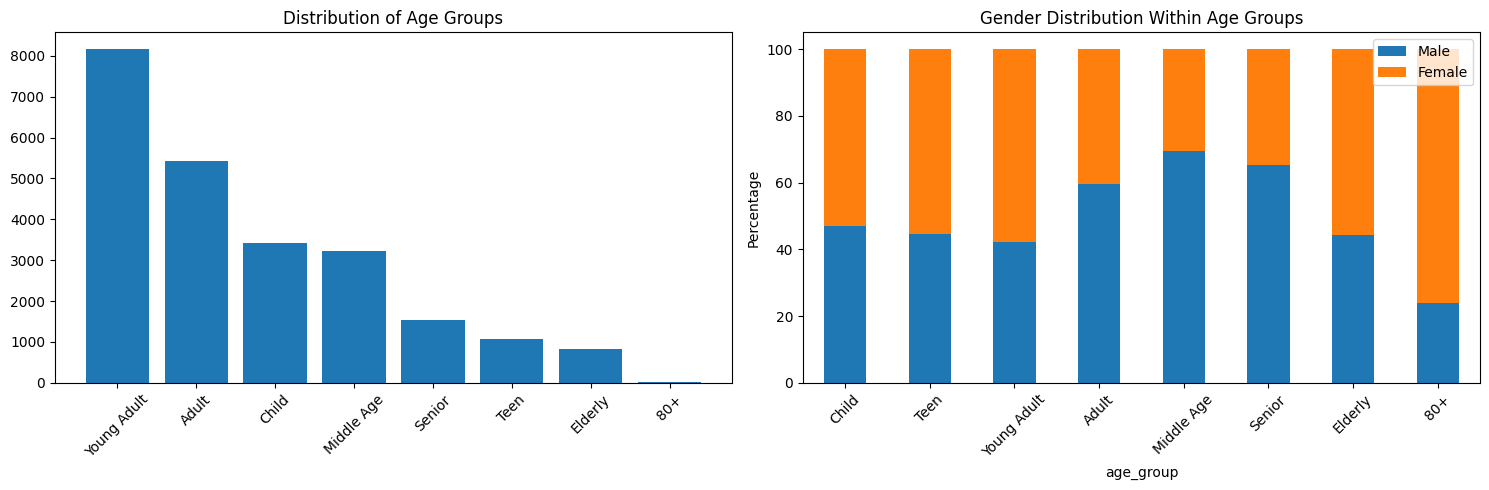


Sample counts by age group:
age_group
Child          3413
Teen           1082
Young Adult    8166
Adult          5433
Middle Age     3216
Senior         1544
Elderly         830
80+              21
Name: count, dtype: int64


In [15]:
analyze_age_groups(df)

Highly imbalanced:

- Young Adult (8,166 samples) and Adult (5,433) dominate
- Teen category is underrepresented (1,082 samples)
- Elderly (830) and 80+ (21) are severely underrepresented

## Data quality issues


Ages with less than 10 samples:
age
91     2
93     5
95     9
99     9
101    2
103    1
105    5
110    5
111    1
115    3
116    4
Name: count, dtype: int64


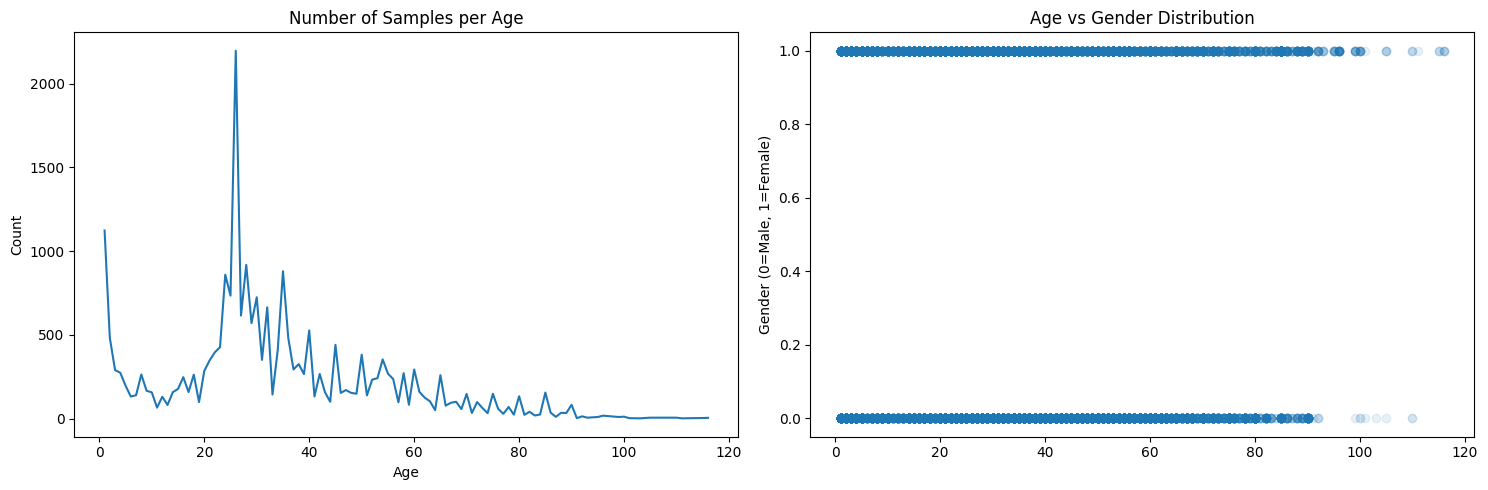

In [12]:
analyze_data_quality(df)

- Significant age gaps in elderly population (91-116 years)
- Very few samples (< 10) for ages above 90
- Strong peak around age 25-35 (potentially overrepresented)
- Sharp drop-off in samples after age 60

## Race distribution and its interaction with other variables

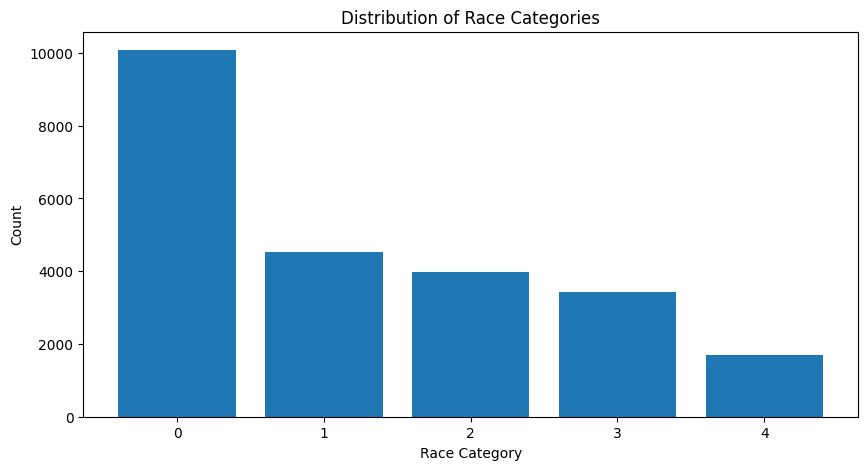


Gender distribution within each race category (%):
gender          0          1
race                        
0       54.346100  45.653900
1       51.215201  48.784799
2       45.864881  54.135119
3       56.880503  43.119497
4       44.917258  55.082742


In [13]:
analyze_race_distribution(df)

- Significant imbalance across race categories
- Race category 0 is heavily overrepresented (~10,000 samples)
- Race category 4 is underrepresented (~2,000 samples)
- Gender distribution varies by race (44-56% range)

In [ ]:
def analyze_age_distributions_by_race(df):
    """Analyze how age distributions vary across different races"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x='race', y='age')
    plt.title('Age Distribution by Race')
    
    plt.subplot(1, 2, 2)
    for race in df['race'].unique():
        sns.kdeplot(data=df[df['race']==race], x='age', 
                   label=f'Race {race}')
    plt.title('Age Density by Race')
    plt.legend()
    plt.show()
    
    print("\nAge Statistics by Race:")
    print(df.groupby('race')['age'].describe())

def analyze_decade_distribution(df):
    """Analyze distribution across decades and demographics"""
    df['decade'] = (df['age'] // 10) * 10  # Calculate decades from age
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    decade_counts = df['decade'].value_counts().sort_index()
    plt.bar(decade_counts.index, decade_counts.values)
    plt.title('Distribution by Decades')
    plt.xlabel('Decade of Life')
    plt.ylabel('Count')
    
    ax2 = plt.subplot(1, 2, 2)
    gender_decade = pd.crosstab(df['decade'], df['gender'], normalize='index') * 100
    gender_decade.plot(kind='bar', stacked=True, ax=ax2)  # Specify ax=ax2
    plt.title('Gender Distribution by Decade')
    plt.xlabel('Decade of Life')
    plt.ylabel('Percentage')
    plt.legend(['Male', 'Female'])
    
    plt.tight_layout()
    plt.show()
    
    print("\nSample counts by decade:")
    print(decade_counts)

def analyze_intersectional_patterns(df):
    """Analyze intersectional patterns between race, gender, and age"""
    plt.figure(figsize=(15, 5))
    
    ax1 = plt.subplot(1, 2, 1)  # Define the first subplot
    race_gender = pd.crosstab(df['race'], df['gender'], normalize='index') * 100
    race_gender.plot(kind='bar', ax=ax1)  # Plot on the first subplot
    ax1.set_title('Gender Distribution Within Race Categories')
    ax1.set_xlabel('Race')
    ax1.set_ylabel('Percentage')
    ax1.legend(['Male', 'Female'])
    
    ax2 = plt.subplot(1, 2, 2)  # Define the second subplot
    avg_age = df.groupby(['race', 'gender'])['age'].mean().unstack()
    avg_age.plot(kind='bar', ax=ax2)  # Plot on the second subplot
    ax2.set_title('Average Age by Race and Gender')
    ax2.set_xlabel('Race')
    ax2.set_ylabel('Average Age')
    ax2.legend(['Male', 'Female'])
    
    plt.tight_layout()
    plt.show()
    
    print("\nDetailed age statistics by race and gender:")
    print(df.groupby(['race', 'gender'])['age'].describe())

def analyze_data_gaps(df):
    """Analyze gaps and anomalies in the dataset"""
    age_range = range(int(df['age'].min()), int(df['age'].max()) + 1)
    missing_ages = [age for age in age_range if age not in df['age'].values]
    
    age_counts = df['age'].value_counts().sort_index()
    rolling_density = age_counts.rolling(window=5, center=True).mean()
    
    plt.figure(figsize=(15, 5))
    plt.plot(age_counts.index, age_counts.values, label='Actual samples')
    plt.plot(rolling_density.index, rolling_density.values, 
             label='5-year rolling average', linestyle='--')
    plt.title('Age Distribution with Rolling Average')
    plt.xlabel('Age')
    plt.ylabel('Number of Samples')
    plt.legend()
    plt.show()
    
    print("\nAges with no samples:")
    print(missing_ages)
    
    print("\nAges with significant deviation from local average:")
    z_scores = (age_counts - rolling_density) / rolling_density.std()
    significant_deviations = z_scores[abs(z_scores) > 2]
    print(significant_deviations)

def analyze_age_demographic_patterns(df):
    """Analyze detailed age distribution patterns within each demographic group"""
    
    plt.figure(figsize=(20, 15))
    
    plt.subplot(2, 2, 1)
    pivot_data = pd.crosstab(df['age'] // 5 * 5, [df['race'], df['gender']])
    sns.heatmap(pivot_data, cmap='YlOrRd', 
                xticklabels=True, yticklabels=True)
    plt.title('Age Distribution Heatmap\n(by Race and Gender)')
    plt.xlabel('Race_Gender')
    plt.ylabel('Age Group (5-year bins)')
    
    plt.subplot(2, 2, 2)
    for race in sorted(df['race'].unique()):
        race_data = df[df['race'] == race]
        sns.kdeplot(data=race_data, x='age', 
                   label=f'Race {race}', alpha=0.6)
    plt.title('Age Distribution by Race')
    plt.xlabel('Age')
    plt.ylabel('Density')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    df['race_gender'] = df['race'].astype(str) + '_' + df['gender'].astype(str)
    sns.boxplot(data=df, x='race_gender', y='age')
    plt.title('Age Spread by Race-Gender Combination')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 4)
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 12, 18, 30, 45, 60, 75, 90, 120],
                            labels=['Child', 'Teen', 'Young Adult', 
                                   'Adult', 'Middle Age', 'Senior', 
                                   'Elderly', '80+'])
    age_race_props = pd.crosstab(df['race'], df['age_group'], 
                                normalize='index') * 100
    age_race_props.plot(kind='bar', stacked=True)
    plt.title('Age Group Proportions within Each Race')
    plt.xlabel('Race')
    plt.ylabel('Percentage')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    print("\nAge statistics for each race-gender combination:")
    print(df.groupby(['race', 'gender'])['age'].describe().round(2))
    
    print("\nPercentage of each age group within races:")
    print(age_race_props.round(2))
    
    print("\nRepresentation ratios (compared to overall dataset):")
    overall_age_dist = df['age_group'].value_counts(normalize=True)
    for race in df['race'].unique():
        race_age_dist = df[df['race'] == race]['age_group'].value_counts(normalize=True)
        ratio = (race_age_dist / overall_age_dist).round(2)
        print(f"\nRace {race} representation ratios:")
        print(ratio)

## Race-specific age distributions and potential biases

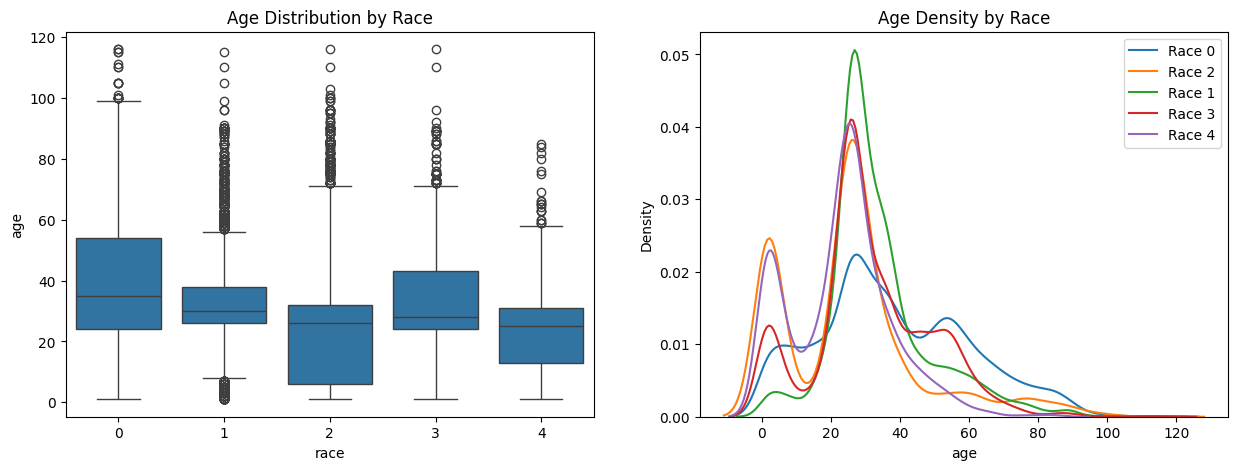


Age Statistics by Race:
        count       mean        std  min   25%   50%   75%    max
race                                                             
0     10078.0  37.980949  21.940727  1.0  24.0  35.0  54.0  116.0
1      4526.0  33.860362  14.825301  1.0  26.0  30.0  38.0  115.0
2      3434.0  25.867501  20.406064  1.0   6.0  26.0  32.0  116.0
3      3975.0  31.532830  16.977719  1.0  24.0  28.0  43.0  116.0
4      1692.0  23.169031  14.488105  1.0  13.0  25.0  31.0   85.0


In [17]:
analyze_age_distributions_by_race(df)

- Race 0 has highest mean age (38 years) and widest distribution
- Race 4 has youngest population (mean 23.2 years)
- Race 2 shows strong bimodal distribution (peaks at young children and young adults)
- Significant disparity in elderly representation across races

## Decade-wise distribution of samples and gender ratios

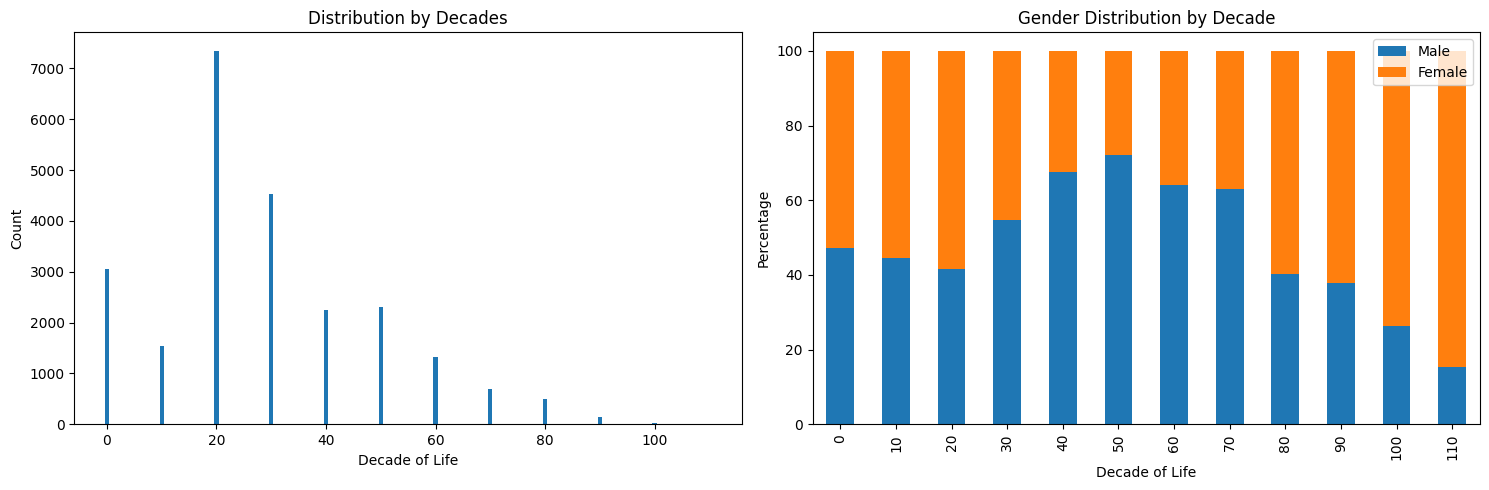


Sample counts by decade:
decade
0      3062
10     1531
20     7344
30     4536
40     2245
50     2299
60     1316
70      699
80      504
90      137
100      19
110      13
Name: count, dtype: int64


In [22]:
analyze_decade_distribution(df)

- Peak in 20s decade (7,344 samples)
- Sharp decline after 50s
- Severe underrepresentation in 80+ (504 samples)
- Gender imbalance increases with age
- Males overrepresented in middle decades (40-70)
- Females overrepresented in younger and very old ages

## Intersectional patterns between race, gender, and age

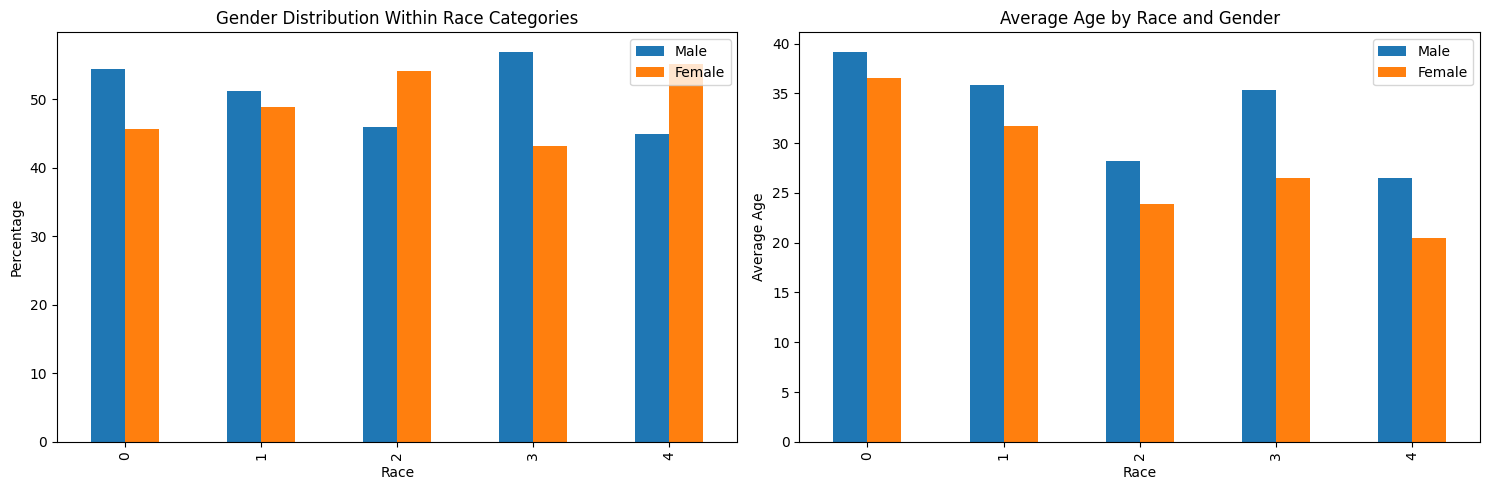


Detailed age statistics by race and gender:
              count       mean        std  min   25%   50%   75%    max
race gender                                                            
0    0       5477.0  39.169071  20.649796  1.0  26.0  37.0  54.0  110.0
     1       4601.0  36.566616  23.308162  1.0  21.0  31.0  53.0  116.0
1    0       2318.0  35.867990  15.525823  1.0  26.0  32.0  43.0   91.0
     1       2208.0  31.752717  13.743738  1.0  26.0  29.0  36.0  115.0
2    0       1575.0  28.252063  23.404337  1.0   3.0  27.0  40.0  110.0
     1       1859.0  23.847230  17.217731  1.0  15.0  25.0  28.0  116.0
3    0       2261.0  35.373728  17.051188  1.0  26.0  35.0  48.0   92.0
     1       1714.0  26.466161  15.490474  1.0  21.0  26.0  31.0  116.0
4    0        760.0  26.522368  15.424072  1.0  19.0  26.0  35.0   82.0
     1        932.0  20.434549  13.062973  1.0   8.0  23.0  27.0   85.0


In [24]:
analyze_intersectional_patterns(df)

- Gender ratios vary significantly by race
- Race 3 shows largest gender-age gap (male mean: 35.4, female mean: 26.5)
- Race 4 shows youngest average age for both genders
- Gender gaps in mean age are consistently present but vary in magnitude

## Data gaps and anomalies across different dimensions

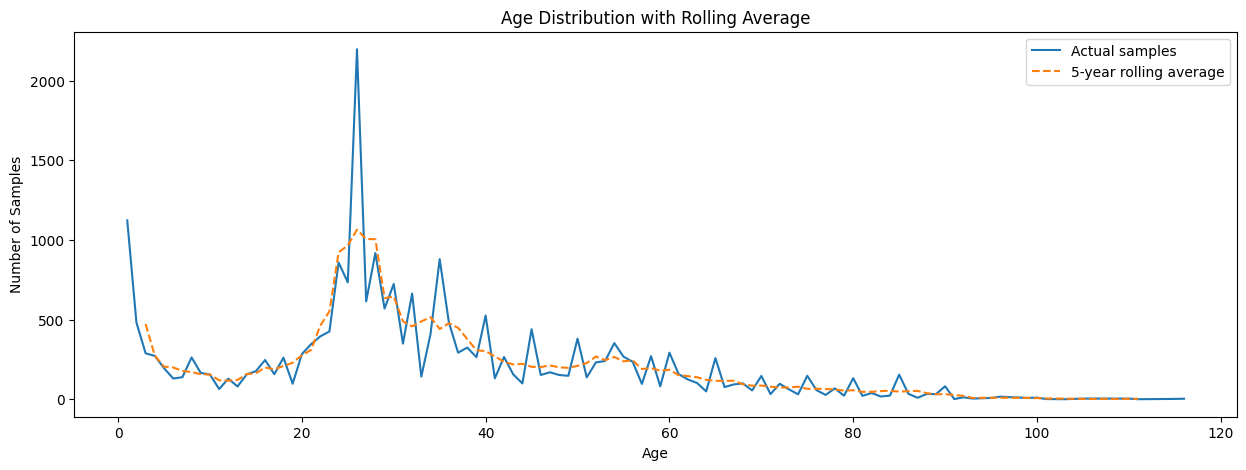


Ages with no samples:
[94, 97, 98, 102, 104, 106, 107, 108, 109, 112, 113, 114]

Ages with significant deviation from local average:
age
26    4.877229
Name: count, dtype: float64


In [20]:
analyze_data_gaps(df)

- Missing samples for ages 94, 97, 98, 102, etc.
- Significant spike at age 26 (over 4.8 standard deviations from local average)
- Sharp drop-offs in certain age ranges

## Age distribution patterns within each demographic group

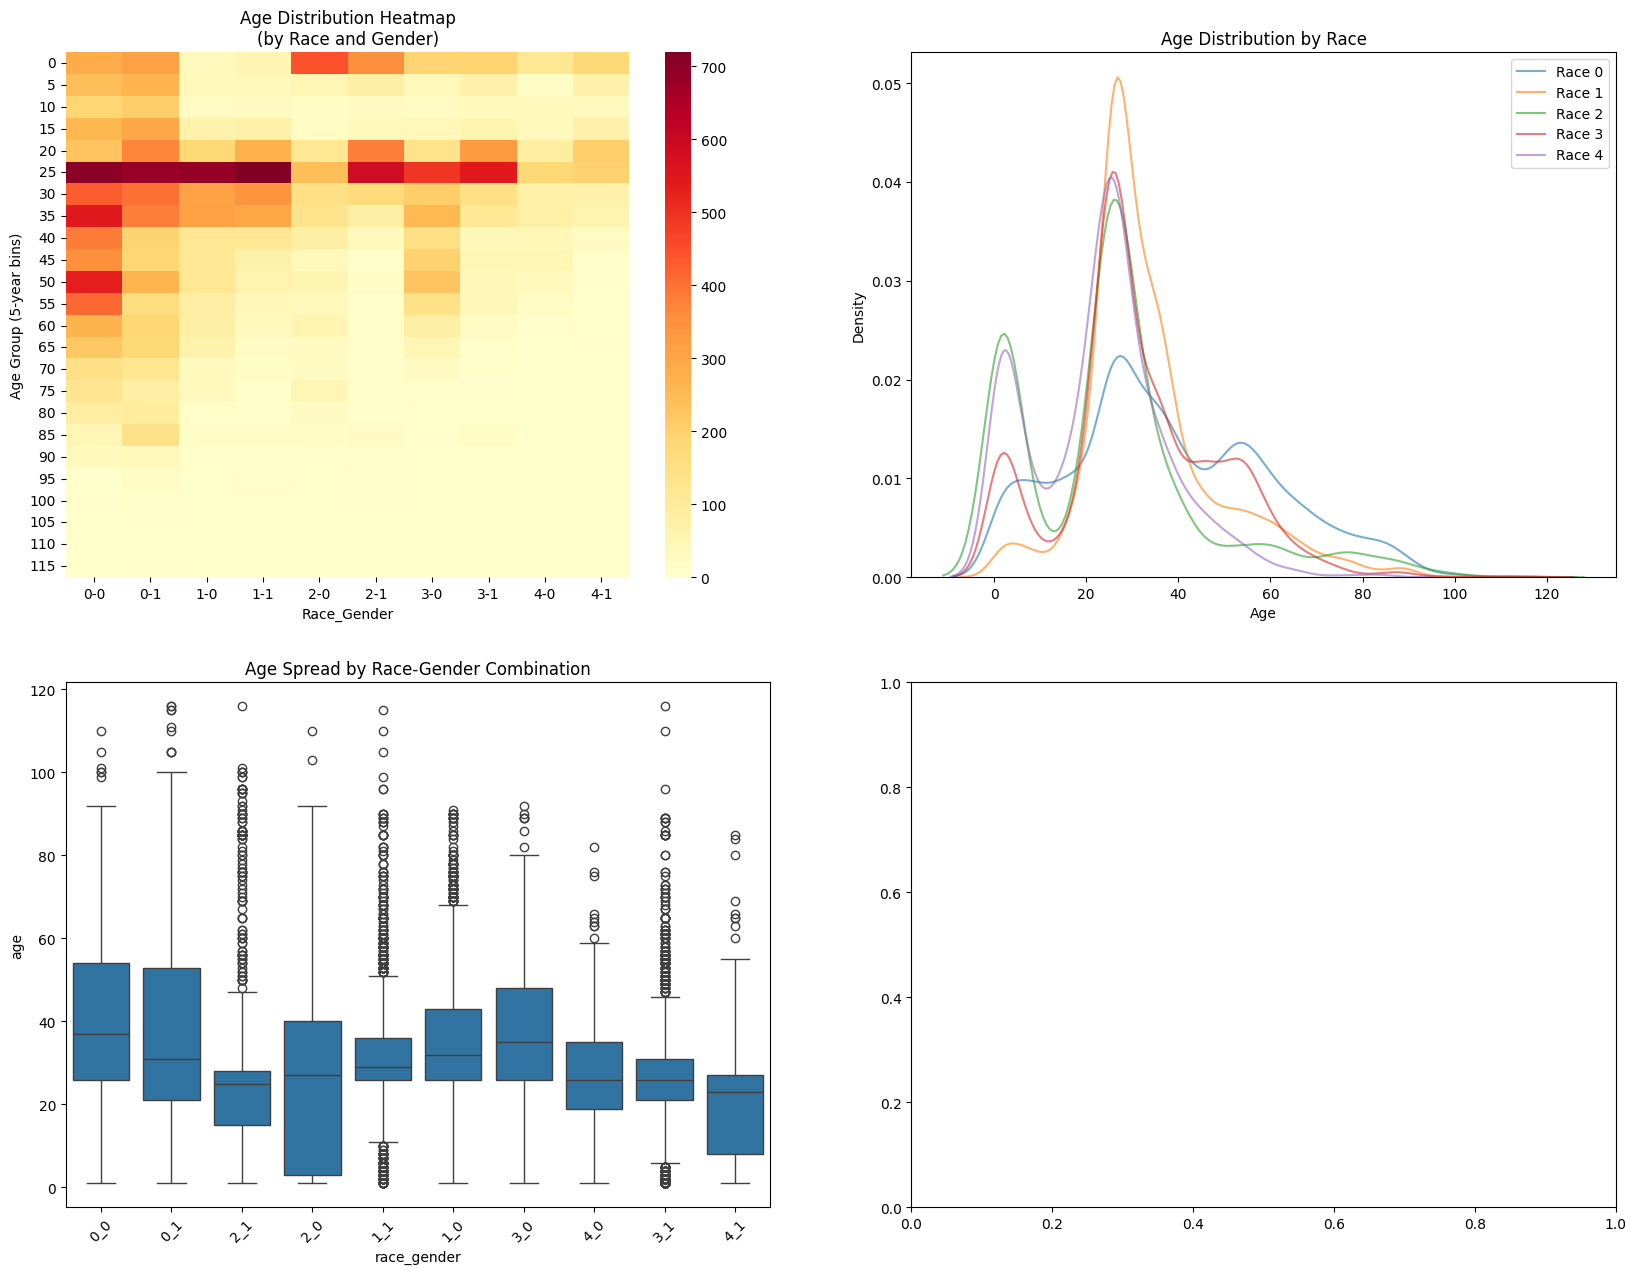

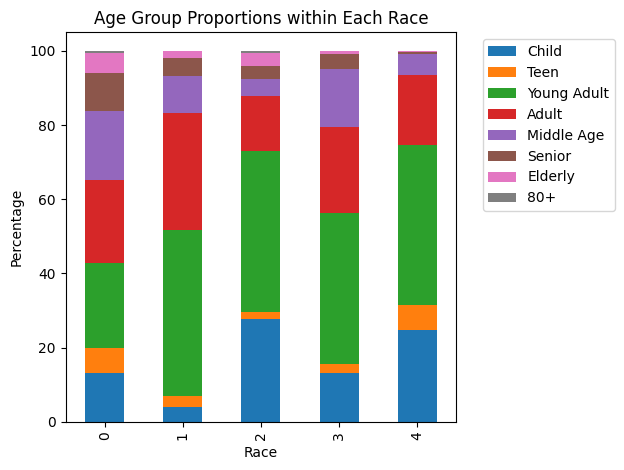


Age statistics for each race-gender combination:
              count   mean    std  min   25%   50%   75%    max
race gender                                                    
0    0       5477.0  39.17  20.65  1.0  26.0  37.0  54.0  110.0
     1       4601.0  36.57  23.31  1.0  21.0  31.0  53.0  116.0
1    0       2318.0  35.87  15.53  1.0  26.0  32.0  43.0   91.0
     1       2208.0  31.75  13.74  1.0  26.0  29.0  36.0  115.0
2    0       1575.0  28.25  23.40  1.0   3.0  27.0  40.0  110.0
     1       1859.0  23.85  17.22  1.0  15.0  25.0  28.0  116.0
3    0       2261.0  35.37  17.05  1.0  26.0  35.0  48.0   92.0
     1       1714.0  26.47  15.49  1.0  21.0  26.0  31.0  116.0
4    0        760.0  26.52  15.42  1.0  19.0  26.0  35.0   82.0
     1        932.0  20.43  13.06  1.0   8.0  23.0  27.0   85.0

Percentage of each age group within races:
age_group  Child  Teen  Young Adult  Adult  Middle Age  Senior  Elderly   80+
race                                                        

In [25]:
analyze_age_demographic_patterns(df)

1. Age Group Distribution Across Races:
- Race 0 (baseline):
  * Most balanced distribution across age groups
  * Overrepresented in elderly categories (1.67x for Elderly)
  * Strong presence in middle age and senior groups

- Race 1:
  * Heavily skewed toward young/working adults (44.65% Young Adult)
  * Significantly underrepresented in children (0.28x ratio)
  * Low elderly representation (0.42x for 80+)

- Race 2:
  * Strong bimodal distribution
  * Highest child representation (27.75%, 1.93x ratio)
  * Very low teen representation (0.39x ratio)
  * High elderly ratio (1.82x for 80+)

- Race 3:
  * Concentrated in young adult to middle age
  * Very low elderly representation (0.20x ratio)
  * Balanced child representation (0.91x ratio)

- Race 4:
  * Youngest overall distribution
  * No 80+ representation (0.00x ratio)
  * Overrepresented in children (1.72x ratio)
  * Severe underrepresentation in senior/elderly groups

2. Critical Biases to Consider:
- Age-Race Intersectionality:
  * Elderly representation varies dramatically by race
  * Child representation shows significant racial disparities
  * Working-age representation is most consistent across races

- Gender-Race-Age Interactions:
  * Consistent gender age gaps across races
  * Largest gender disparities in Race 3 and 4
  * Gender imbalances increase with age in most races

3. Implications for Model Development:
We need to address these biases through:
1. Stratified sampling across age-race-gender combinations
2. Age-specific loss weighting
3. Separate evaluation metrics for underrepresented groups
4. Data augmentation strategies for minority combinations
5. Careful consideration of model applications where these biases could cause harm
